# <font  color = "#0093AF">Defaults, Constants, and Tools</font>

SLEEPY relies on a few default settings, numerical constants, and includes a toolbox. These are all found in the main SLEEPY module:
```
sl.Defaults     #Python dictionary containing defaults
sl.Constants    #Python dictionary containing constants
sl.Tools        #Pythong sub-module containing tools
```

These are summarized here

## Setup

In [1]:
# SETUP SLEEPY
import os
os.chdir('../../..')

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## Defaults

* `rtype`,`ctype`: Default numpy data types for real and complex data
    - We do not recommend changing these. Numpy does not support higher precision data types for all calculations, and lower precision data types do not result in significant speed up in calculations (although should reduce memory usage).
    
* `parallel`,`ncores`: Flag to activate parallel processing over the powder average and the number of cores to use
    - Parallel processing is not always beneficial, because the implemented linear algebra libraries in the BLAS and LAPACK libraries are already fairly optimized for parallel calculations, whereas Python's parallelism introduces communication overhead (this can be system-dependent). Use ncores where SLEEPY should not use all cores available.
    
* `verbose`: Activates text outputs from SLEEPY.
    - Especially where one loops over many simulations, the text outputs can get annoying and can be turned off here.
    
* `zoom`: Create plots with sliders for zooming in on the various axes. 
    - By default, off unless running in Google Colab or MyBinder, but can be turned on for any Jupyter-like Notebook. Note that in Colab, this setting will restrict post-editing of the figure axis. For locally-run Jupyter Notebooks, a nice alternative to `zoom` is to run `%matplotlib notebook` in a cell, which activates zoomable plots with the cursor (no sliders). However, for many other notebook implementations, `%matplotlib notebook` will break matplotlib outputs (for example, in Binder or Colab).
    
* `Colab`,`Binder`: Each of these flags is set to True if running in Colab or Binder, respectively. 
    - These will changing 'zoom' behavior and the dark-mode coloring. Note that when Colab is in dark mode when SLEEPY is imported, SLEEPY will also switch into to dark mode. This can be turned on and off with `sl.set_dark(True/False)`

In [3]:
sl.Defaults

{'rtype': numpy.float64,
 'ctype': numpy.complex128,
 'parallel': False,
 'cache': True,
 'ncores': None,
 'verbose': True,
 'zoom': False,
 'Colab': False,
 'Binder': False}

# Constants

SLEEPY loads a few physical constants for calculations. 

* $h$ = $6.62607015\times10^{-34}$ J$\cdot$s: Planck constant
* $k_B$ = $1.380649\times10^{-23}$ J/K: Boltzmann constant
* $\mu_B$ = $-13996244936.072704$ Hz/T: Bohr magneton
* $g_e$ = $2.00231930436092$ : Free electron g-factor (unitless)
* $\mu_n$ = $7622593.158495312$ Hz/T: Nuclear magneton
* $\mu_0$ = $1.256637\times10^{-6}$ T$^2\cdot$m$^3$/J: Vacuum Permeability

The Planck constant is used to calculate energy from frequencies, and the Boltzmann constant is used with these energies to calculate equilibrium density matrices. The Bohr magneton is used with the free electron g-factor to calculate the electron Gyromagnetic ratio. This is in turn used as reference for the electron carrier frequency. $\mu_0$ is used for calculating dipole couplings.

These constants can be user-adjusted. Note that adjusting $\mu_n$ after loading SLEEPY will *not* affect the nuclear gyromagnetic ratios because these are calculated when SLEEPY loads. However, adjusting $g_e$ will change the electron gyromagnetic ratio and in turn, change the electron carrier frequency (resulting in shifting spectra). Adjustments to $h$ and $k_B$ will affect thermal equilibrium calculations, and adjusting $\mu_0$ will change dipole coupling calculations.

In [4]:
sl.Constants

{'h': 6.62607015e-34,
 'kB': 1.380649e-23,
 'mub': -13996244936.072704,
 'ge': 2.0023193043609235,
 'mun': 7622593.158495312,
 'mu0': 1.256637e-06}

## Tools

SLEEPY has a variety of tools for help setting up simulations or obtaining general useful information. These are discussed here.

### NucInfo
`sl.Tools.NucInfo` provides information about nuclei. It may be indexed (`NucInfo[...]`) with the name of a nucleus, or called as a function. Using the chemical symbol without mass number will return all isotopes of that element. Calling by default returns the gyromagnetic ratio in Hz/T. One may also set `info=...` and request 'gyro', 'mass', 'spin', 'abund', or 'all', which returns a dictionary with all values. For calls (`NucInfo(...)`), if only the chemical symbol is provided ('H', 'N','U', etc.), then it will try to guess the desired nucleus (priority: spin 1/2, non-zero spin, abundance, so 'H'->'1H', 'C'->'13C', 'U'->'235U').

In [5]:
sl.Tools.NucInfo('H')  #Returns 1H gyroratio 

42577478.05321166

In [6]:
sl.Tools.NucInfo('13C',info='all')  #Returns all info about 13C

{'Nuc': 'C',
 'mass': 13.0,
 'spin': 0.5,
 'gyro': 10708398.762252755,
 'abundance': 0.010700000000000001}

In [7]:
sl.Tools.NucInfo['15N']  #Returns all info about 15N (exact match required)

                     0
Nuc                  N
mass              15.0
spin               0.5
gyro        -4317266.6
abundance      0.00368

[1 experiments with 5 parameters]

In [8]:
sl.Tools.NucInfo['O'] #Returns all types of Oxygen

                     0           1           2
Nuc                  O           O           O
mass              16.0        17.0        18.0
spin               0.0         2.5         0.0
gyro               0.0  -5774236.2         0.0
abundance   0.99757000  0.00037999  0.00204999

[3 experiments with 5 parameters]

### dipole_coupling
Calculates the dipole coupling between two nuclei (or electron). Input is the distance between the nuclei in Angstroms and the names of the two nuclei. Output is the *anisotropy* (`delta`) of the dipole coupling in Hz, which is twice as large as some other definitions of the dipole. If using this function, the output value should be assigned to `delta` when adding a dipole coupling to a system (assign `D` if using half this value for the `dipole` interaction).

e.g.:
```
ex.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(.102,'15N','1H'))
```

In [9]:
sl.Tools.dipole_coupling(.109,'1H','13C')

46656.37350022942

### Exchange matrices
Sleepy calculates a number of different exchange matrices. One provides a correlation time to define these matrices. This correlation time is the inverse of the non-zero eigenvalue (or inverse of the mean of the non-zero eigenvalues). This effective correlation time is the correct value to be applied, for example, for model-free calculations. For a 2-site exchange, for example, $\tau_c=1/(k_{12}+k_{21})$.

* `twoSite_kex`: Two-site exchange with correlation time and optionally populations as input. 


* `nSite_sym`: Returns an exchange matrix over $n$-sites, where all sites are equally populated, and all exchange rate constants are the same. Input is the number of sites and the correlation time. Note that while there are $n-1$ non-zero eigenvalues to this matrix, all eigenvalues are the same.


* `fourSite_sym`: Same as above, but specifically for four sites. Usually paired with tetrahedral hopping.


* `tumbling`: Takes either a 3-site or 4-site symmetric hop, or a "repulsion" powder average, and calculates an exchange matrix to mimic tumbling. The rates are adjusted so that the mean non-zero eigenvalue matches the input correlation time. Also returns Euler angles (usually, not directly used by the user; rather use `sl.Tools.SetupTumbling`, see below). Number of angles is determined by an integer quality factor, `q`. Tumbling does not currently include an average around the $\gamma$-angle.



[1] G. Lipari, A. Szabo. [J. Am. Chem. Soc.](https://doi.org/10.1021/ja00381a010), **1982**, 104, 4559-4579.

In [10]:
print(sl.Tools.twoSite_kex(tc=1e-3,p1=.75))  #Two-site, asymmetric exchange

[[-250.  750.]
 [ 250. -750.]]


In [11]:
print(sl.Tools.nSite_sym(n=5,tc=1e-3))    #Five-site, symmetric exchange

[[-800.  200.  200.  200.  200.]
 [ 200. -800.  200.  200.  200.]
 [ 200.  200. -800.  200.  200.]
 [ 200.  200.  200. -800.  200.]
 [ 200.  200.  200.  200. -800.]]


In [4]:
kex,euler=sl.Tools.tumbling(q=2,tc=1e-3)
for k in kex:
    print(' '.join([f'{k0:6.1f}' for k0 in k]))

-768.1  180.7    0.0  173.4  173.2  119.8    0.0    0.0    0.0  121.0
 180.7 -752.9    0.0    0.0    0.0  180.9   28.9  180.3    0.0  182.2
   0.0    0.0 -753.7  181.6  180.9    0.0  180.8   28.9  181.5    0.0
 173.4    0.0  181.6 -769.3  120.0    0.0  121.3    0.0    0.0  173.1
 173.2    0.0  180.9  120.0 -768.4  173.7    0.0    0.0  120.5    0.0
 119.8  180.9    0.0    0.0  173.7 -768.1    0.0  120.2  173.4    0.0
   0.0   28.9  180.8  121.3    0.0    0.0 -797.5  173.3  119.7  173.4
   0.0  180.3   28.9    0.0    0.0  120.2  173.3 -796.5  173.6  120.2
   0.0    0.0  181.5    0.0  120.5  173.4  119.7  173.6 -768.8    0.0
 121.0  182.2    0.0  173.1    0.0    0.0  173.4  120.2    0.0 -769.9


Note that the eigenvalues of the above matrix are not all identical, but span a fairly small range where the amplitude is significant, making it a good approximation for tumbling. The inverse of the weighted average of the eigenvalues matches the input correlation time (use `kex2A` to verify)

### Back-calculating the correlation function

SLEEPY provides a tool, `kex2A`, which will calculate the order parameter (`S2`), populations (`peq`), correlation times(`tc`), and weights of the correlation times (`A`) resulting from a given exchange matrix and the corresponding set of euler angles. From `S2`, `tc`, and `A`, it is possible to calculate the correlation function, according to:
\begin{equation}
C(t)=S^2+(1-S^2)\sum_i{A_i\exp(-t/\tau_i)}
\end{equation}
As code, this looks like:

In [5]:
S2,peq,tc,A=sl.Tools.kex2A(kex,euler)
t=np.linspace(0,5e-3,200)
Ct=S2+(1-S2)*np.sum([A0*np.exp(-t/tc0) for A0,tc0 in zip(A,tc)],axis=0)

kavg=(1/tc*A).sum()

ax=plt.subplots()[1]
ax.plot(t*1e3,Ct)
sl.plot_tools.ColabZoom(ax)
ax.plot(t*1e3,S2+(1-S2)*np.exp(-t*kavg),color='black',linestyle=':')
ax.legend(('C(t)','MonoExponential'))
ax.set_xlabel('t / ms')
_=ax.set_ylabel('C(t)')

Output()

In [16]:
print(f'S2 = {S2:.5f}')

S2 = 0.00023


As we see, the model for tumbling yields a very nearly monoexponential correlation function, with an order parameter of nearly zero. We later use tumbling 

In [13]:
for tc0,A0 in zip(tc,A):
    print(f'k:{1/tc0:.1f}, A:{A0:.2f}')

k:1171.6, A:0.00
k:1033.0, A:0.18
k:1024.3, A:0.20
k:1012.3, A:0.19
k:1010.6, A:0.19
k:938.9, A:0.24
k:534.8, A:0.00
k:526.2, A:0.00
k:461.6, A:0.00


Below, we calculate the inverse amplitude-weighted rate constants, to verify that it is equal 

In [14]:
kavg=((1/tc)*A).sum()
print(f'1/<k> = {1/kavg} s')

1/<k> = 0.001 s


### Exchange setup tools

SLEEPY has three tools for setting up orientational exchange simulations, which handles both construction of an exchange matrix, and construction of the spin-systems in exchange starting from a reference system (`ExpSys`). For example:

In [3]:
ex=sl.ExpSys(v0H=600,Nucs=['1H','13C'],vr=0,pwdavg='alpha0beta0')
ex.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(.109,'1H','13C'))
ex.set_inter('CS',i=1,ppm=5)
ex_list,kex=sl.Tools.SetupTumbling(ex,tc=1e-9,q=2)

L=sl.Liouvillian(ex_list,kex=kex)

In [4]:
S2,peq,tc,A=sl.Tools.kex2A_expsys(kex,ex_list)
t=np.linspace(0,5e-3,200)
Ct=S2+(1-S2)*np.sum([A0*np.exp(-t/tc0) for A0,tc0 in zip(A,tc)],axis=0)

kavg=(1/tc*A).sum()

ax=plt.subplots()[1]
ax.plot(t*1e3,Ct)
ax.plot(t*1e3,S2+(1-S2)*np.exp(-t*kavg),color='black',linestyle=':')
ax.legend(('C(t)','MonoExponential'))
ax.set_xlabel('t / ms')
_=ax.set_ylabel('C(t)')

ValueError: not enough values to unpack (expected 2, got 1)

Then, `ex_list` has the same interactions as `ex`, but with Euler angles derived from the 'rep10' powder average appended to each interaction, in this case to mimic tumbling in solution.

In [4]:
print(f'ex_list contains {len(ex_list)} systems in exchange')

ex_list contains 10 systems in exchange


We can use the `L.plot` function to visualize the resulting exchange matrix.

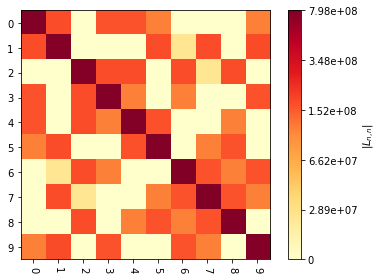

In [6]:
_=L.plot(what='kex')

The following setup tools are implemented:
* `Setup3siteSym` : 